## Seminar 12. Part 2. Andrews-Curtis conjecture





We now turn our attention to the paper "What makes math problems hard for reinforcement learning: a case study."  by A. Shehper et al.
https://arxiv.org/pdf/2408.15332

In [1]:
!pip install gymnasium


* `pip install ac-solver` is incompatible with Colab and will cause errors. Downloading the repository  https://github.com/shehper/AC-Solver instead.




In [2]:
!git clone https://github.com/shehper/AC-Solver.git
!cd AC-Solver

Cloning into 'AC-Solver'...
remote: Enumerating objects: 876, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 876 (delta 34), reused 77 (delta 23), pack-reused 777 (from 1)
Receiving objects: 100% (876/876), 1.12 MiB | 5.20 MiB/s, done.
Resolving deltas: 100% (454/454), done.


## Imports

In [3]:
import sys
sys.path.append('/content/AC-Solver')

from collections import defaultdict
from importlib import resources
import numpy as np
import torch
import matplotlib.pyplot as plt
from ast import literal_eval

from ac_solver.envs.ac_env import ACEnv

# 1. What is Andrew-Curtic conjecture?

The **Andrews-Curtis Conjecture** (or AC, for short) proposes that any balanced presentation of the trivial group $$\langle x_1, \dots, x_n \bigr| r_1, \dots, r_n \rangle$$ can be converted to the trivial presentation $$\langle x_1, \dots, x_n \bigr| x_1, \dots, x_n \rangle$$ through a series of the following operations known as **AC-moves**:

1. (AC1) Substitute some $r_i$ by $r_i r_j$ for $i \not = j$.
2. (AC2) Replace some $r_i$ by $r_i^{-1}$.
3. (AC3) Change some $r_i$ to $g r_i g^{-1}$ where $g$ is a generator or its inverse.

The sum of the word lengths of all relators as the **length** of a
presentation. Below we consider groups with two generators $$\langle x, y \bigr| r_1, r_2 \rangle.$$

## 1.1 RL setting

Let's define the search space using Python objects. An element in this space is a pair of tuples, with each tuple containing elements from the set $1, -1, 2$, or $-2$. (Note: Not all pairs are valid.)

* In Math, $1, 2, -1$, and $-2$ are often written as $x$, $y$, $x^{-1}$, and $y^{-1}$. A pair of tuples is often written using angle brackets, so that `[(1, 2, -1), (2, 1)]` is written as $\langle x, y | x y x^{-1}, yx \rangle$

Two elements are connected if they're related by a sequence of the following actions:

1. (AC1) **Concatenation:** You can concatenate one tuple with another. For example, `[(1, 2, -1), (2, 1)]` is connected to `[(1, 2, -1), (2, 1, 1, 2, -1)]` and `[(1, 2, -1, 2, 1), (2, 1)]`.

2. (AC2) **Inversion:** You can replace a tuple with its reverse and negative version. For example, `(2, 1, 2, -1)` could be replaced with `(1, -2, -1, -2)`.

3. (AC3) **Conjugation:** You can prepend a tuple with any of the four elements `(1, -1, 2, -2)`, while also appending its negative at the end. For instance, `(1, 2, -1)` can be changed to `(-2, 1, 2, -1, 2)`.

The AC conjecture proposes that there’s a path between every element in this space and the "trivial state" `[(1,), (2,)]`.



## 1.2 Applying AC-moves, correcting misprints

The authors identified a misprint in the paper ``On the Andrews-Curtis equivalence'' by A.D.Myasnikov et al. (2002) (see Appendix F of  https://arxiv.org/pdf/2408.15332). Consider the group
$$\langle x, y \bigr| x^{−1}y^{−1}xy^{−1}x^{−1}yxy^{−2}xyx^{−1}y, y^{−1}x^{−1}y^2x^{−1}y^{−1}xyxy^{−2}x\rangle.$$ We represent it as follows.

In [4]:
relator1 = [-1,-2,1,-2,-1,2,1,-2,-2,1,2,-1,2]
relator2 = [-2,-1,2,2,-1,-2,1,2,1,-2,-2,1]

Next, we pad these tuples with zeros to reach max_length and then concatenate the two resulting tuples.

In [ ]:
from ac_solver.envs.utils import convert_relators_to_presentation

max_length = 15

presentation = convert_relators_to_presentation(
    relator1=relator1,
    relator2=relator2,
    max_relator_length=max_length,
)

print(presentation)

[-1 -2  1 -2 -1  2  1 -2 -2  1  2 -1  2  0  0 -2 -1  2  2 -1 -2  1  2  1
 -2 -2  1  0  0  0]


A notable family of potential counterexamples, denoted $\operatorname{AK} (n)$, due to Akbulut
and Kirby,  $$\operatorname{AK}(n) = \langle x, y | x^n = y^{n+1}, xyx = yxy\rangle, \quad n \geq 3.$$

* The identified misprint was resolved by *showing a sequence of AC-moves connecting the group to AK(3)*.

There are $12$ moves:


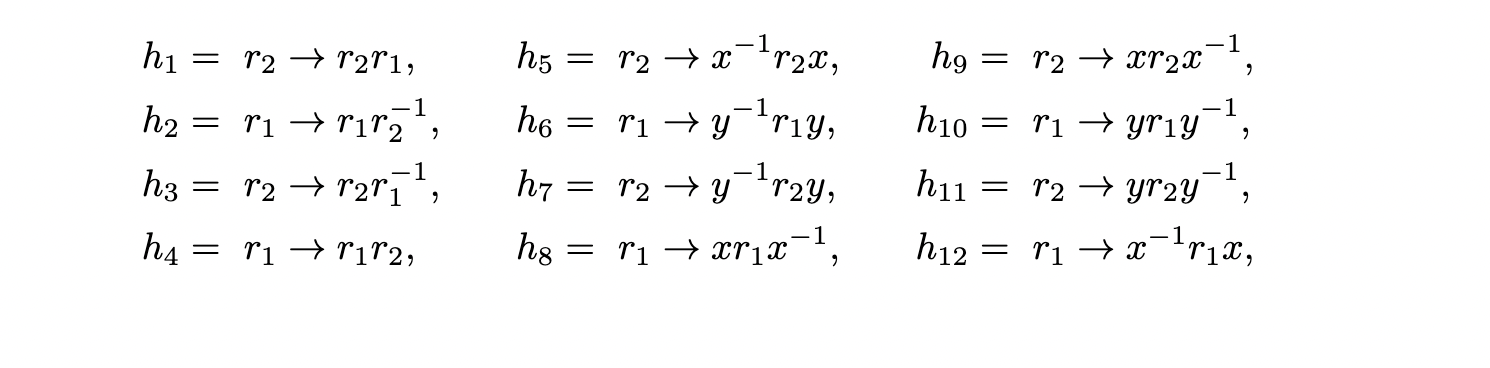

In [ ]:
from ac_solver.envs.ac_moves import ACMove

sequence = [
    9, 7, 4, 8, 11, 5, 11, 9, 3, 10, 12, 7, 7, 9, 11, 5, 3, 5, 4, 3, 12, 5, 7, 7, 1, 9, 11,
    8, 3, 5, 10, 2, 6, 12, 9, 7, 5, 11, 10, 3, 8, 11, 9, 2, 10, 12, 5, 7, 9, 11, 1, 9, 8
]

state, lengths = presentation, [13, 12]
for move_id in sequence:
    state, lengths = ACMove(move_id=move_id-1, # minus one as ACMove
                            presentation=state,
                            max_relator_length=15,
                            lengths=lengths,
                            cyclical=False # whether to cyclically reduce words
                                           # in the resultant presentation or not
                            )

print(f"Note that the following state is AK(3): {state}")

Note that the following state is AK(3): [ 1  1  1 -2 -2 -2 -2  0  0  0  0  0  0  0  0  1  2  1 -2 -1 -2  0  0  0
  0  0  0  0  0  0]


## 1.3 Example from Appendix B

We take example from Appendix B of https://arxiv.org/pdf/2408.15332 The group is given by $$\langle x,y \bigr| x^{-1}y^4x y^{-5}, \quad x^{-1}yxy^{-1}x^{-1}y^{-3}\rangle$$


Unfortunately, we were unable to reproduce the reported results. There might be a misprint somewhere.

In [ ]:
from ac_solver.envs.utils import convert_relators_to_presentation

relator1 = [-1,2,2,2,2,1,-2,-2,-2,-2,-2]
assert len(relator1) == 11
relator2 = [-1,2,1,-2,-1,-2,-2,-2]
assert len(relator2) == 8

max_length = 15

presentation = convert_relators_to_presentation(
    relator1=relator1,
    relator2=relator2,
    max_relator_length=max_length,
)

assert len(presentation) == 2*max_length
print(presentation)

[-1  2  2  2  2  1 -2 -2 -2 -2 -2  0  0  0  0 -1  2  1 -2 -1 -2 -2 -2  0
  0  0  0  0  0  0]


Sequence of $381$ moves

In [ ]:
sequence = [2, 8, 6, 4, 10, 2, 8, 6, 6, 8, 10, 10, 10, 7, 0, 4, 6, 6,
            6, 6, 11, 8, 10, 10, 2, 8, 6, 4, 10, 2, 8, 6, 6, 6, 8, 10,
            10, 10, 7, 3, 5, 5, 5, 0, 4, 6, 11, 5, 9, 7, 11, 7, 11, 5,
            4, 9, 2, 8, 6, 6, 6, 8, 10, 8, 10, 10, 4, 7, 0, 4, 6, 11,
            2, 8, 6, 6, 8, 10, 8, 10, 2, 8, 4, 10, 7, 0, 4, 6, 4, 11,
            10, 2, 8, 6, 4, 10, 8, 7, 0, 4, 6, 11, 4, 7, 11, 2, 8, 6,
            2, 8, 6, 8, 8, 10, 7, 0, 4, 0, 4, 0, 4, 0, 4, 6, 11, 2,
            8, 6, 4, 6, 8, 8, 10, 10, 10, 10, 2, 8, 6, 4, 10, 8, 7, 0,
            4, 6, 11, 4, 2, 8, 6, 6, 8, 8, 10, 10, 7, 0, 4, 0, 4, 6,
            11, 8, 7, 11, 5, 4, 8, 11, 7, 4, 8, 11, 7, 9, 6, 8, 8, 10,
            4, 10, 10, 8, 2, 8, 6, 7, 8, 11, 8, 10, 4, 10, 10, 2, 8, 6,
            4, 6, 8, 8, 8, 10, 7, 11, 7, 4, 11, 10, 7, 0, 4, 6, 11, 4,
            2, 8, 6, 8, 8, 8, 10, 7, 0, 4, 0, 4, 0, 4, 6, 8, 11, 2,
            8, 8, 10, 10, 10, 2, 8, 2, 8, 6, 4, 6, 8, 10, 8, 10, 10, 7,
            0, 4, 6, 11, 4, 2, 8, 6, 4, 2, 8, 6, 8, 10, 7, 11, 7, 5,
            11, 8, 10, 4, 8, 9, 7, 4, 8, 9, 7, 0, 4, 0, 4, 6, 11, 5,
            9, 4, 2, 8, 6, 4, 6, 8, 8, 10, 10, 7, 0, 4, 6, 11, 6, 8,
            8, 10, 4, 10, 2, 8, 6, 8, 8, 10, 7, 11, 7, 5, 11, 9, 7, 9,
            7, 4, 0, 4, 6, 11, 8, 8, 8, 10, 7, 0, 4, 6, 4, 11, 10, 2,
            8, 8, 8, 10, 7, 0, 4, 6, 11, 4, 2, 8, 8, 2, 8, 10, 2, 8,
            6, 4, 6, 8, 10, 7, 0, 4, 6, 11, 8, 8, 8, 8, 8, 8, 8, 1,
            7, 5, 11]

assert len(sequence) == 381

The final state is not trivial

In [ ]:
from ac_solver.envs.ac_moves import ACMove

state, lengths = presentation, [11, 8]
for move_id in sequence:
    state, lengths = ACMove(move_id=move_id,
                            presentation=state,
                            max_relator_length=15,
                            lengths=lengths,
                            cyclical=False
                            )

print(f"Final state: {state}")

Final state: [-2 -2 -2 -1  2  2  2  2  1 -2 -2  0  0  0  0 -2 -2 -2 -2 -2 -2 -2 -1  2
  2 -1  2  1  2  0]


# 2. Comparison of  Breadth First Search, Greedy Search, and PPO

The authors considered a family of potential counterexamples: $$\operatorname{MS}(n, w) = \langle x, y | x^{−1}y^nx = y^{n+1}, x = w \rangle.$$ Here, $n\geq 1$ is a positive integer and $w$ is a word in $x$ and $y$ with zero exponent sum
on $x$. Focusing on $n \leq 7$ and $\operatorname{length}(w) \leq 7$ they identified 170 presentations for each n, resulting in a dataset of 1190 presentations for analysis. Three algorithms were used:

1. **Breadth-First Search** (BFS) explores the state space level by level, starting from the initial balanced presentation, until a trivial presentation is found or a maximum of N states are visited.

2. **Greedy Search** is similar to BFS but uses a priority queue. States are prioritized by presentation length ($k$) and then path length ($l$), dequeuing the state with the smallest $(k, l)$.

3. **Proximal Policy Optimization** (PPO).

Let's load the results.

  

In [5]:
## Load data
import sys, os # Importing sys and os modules
sys.path.append(os.path.abspath('AC-Solver')) # Adding the local repository path to sys.path

## Load data
filename = "greedy_search_paths.txt"
with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
    gs_paths = [literal_eval(path) for path in file]

filename = "greedy_solved_presentations.txt"
with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
    gs_solved = [np.array(literal_eval(presentation)) for presentation in file]

filename = "bfs_solved_presentations.txt"
with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
    bfs_solved = [np.array(literal_eval(presentation)) for presentation in file]

filename = "all_presentations.txt"
with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
    all_presentations = [np.array(literal_eval(presentation)) for presentation in file]

<ipython-input-5-3390530283>:7: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
<ipython-input-5-3390530283>:11: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
<ipython-input-5-3390530283>:15: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_text('ac_solver.search.miller_schupp.data', filename) as file:
<ipython-input-5-3390530283>:19: DeprecationWarning: open_text is deprecated. Use files() instead.

Load the PPO model

In [6]:
import torch
import requests
from pathlib import Path
import numpy as np  # Import numpy for scalar definition

# URL of the file on Google Drive
url = "https://drive.google.com/uc?id=1hjCReTkrrNKGbz2X0jEhpAPKBby0MczQ&export=download"
filename = "ppo.pt"

# Define the path where the checkpoint will be saved
ckpt_path = Path("/tmp") / filename

# Download the file if it does not exist
if not ckpt_path.exists():
    print(f"Downloading {filename} from Google Drive...")
    response = requests.get(url, stream=True)
    with open(ckpt_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Downloaded {filename} to {ckpt_path}")


# Define the numpy scalar class
scalar = np.core.multiarray.scalar

# Add the numpy scalar to the safe globals list
torch.serialization.add_safe_globals([scalar])

# Load the checkpoint with weights_only=False and add the safe global
ppo_checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)


id_to_ac_seq_dict = ppo_checkpoint['ACMoves_hist']
print(f"The loaded checkpoint of PPO agent solved {len(id_to_ac_seq_dict)} presentations.")

Downloaded ppo.pt to /tmp/ppo.pt
The loaded checkpoint of PPO agent solved 431 presentations.


<ipython-input-6-4070187591>:25: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  scalar = np.core.multiarray.scalar


For each n and presentation, get the number of examples that each of the three algorithms solve


In [7]:
## Initiate data
# GS
n_to_gs_num_solved = [0]*7
length_to_gs_num_solved = defaultdict(int)

# BFS
n_to_bfs_num_solved = [0]*7
length_to_bfs_num_solved = defaultdict(int)

# PPO
n_to_ppo_solved = [0]*7
length_to_ppo_num_solved = defaultdict(int)

# All presentations
length_to_num_presentations = defaultdict(int)

for id, presentation in enumerate(all_presentations):

    # compute n
    max_relator_length = len(presentation) // 2
    first_relator = presentation[:max_relator_length]
    n = (np.count_nonzero(first_relator) - 3) // 2

    # compute total presentation length
    presentation_length = np.count_nonzero(first_relator) + np.count_nonzero(presentation[max_relator_length:])

    ## record info
    length_to_num_presentations[presentation_length] += 1

    # record info for GS
    if any(np.array_equal(presentation, arr) for arr in gs_solved):
        length_to_gs_num_solved[presentation_length] += 1
        n_to_gs_num_solved[n-1] += 1

    # record info for BFS
    if any(np.array_equal(presentation, arr) for arr in bfs_solved):
        n_to_bfs_num_solved[n-1] += 1
        length_to_bfs_num_solved[presentation_length] += 1

    # record info for PPO
    if id in ppo_checkpoint["success_record"]["solved"]:
        n_to_ppo_solved[n-1] += 1
        length_to_ppo_num_solved[presentation_length] += 1

We compare the performance of algorithms as a function of $n$ for $\operatorname{MS}(n, w)$.

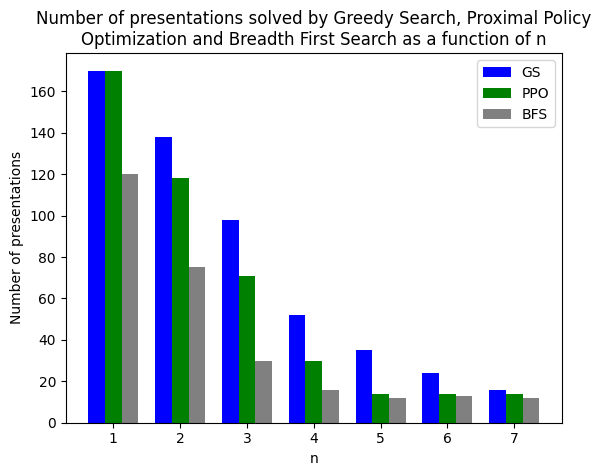

In [8]:
n = ['1', '2', '3', '4', '5', '6', '7']
X_axis = np.arange(len(n))

# Width of the bar
barWidth = 0.25

# Set position of bar on X axis
r1 = X_axis - barWidth
r2 = X_axis
r3 = X_axis + barWidth

# Make the plot
plt.bar(r1, n_to_gs_num_solved, width=barWidth, label='GS', color='blue')
plt.bar(r2, n_to_ppo_solved, width=barWidth, label='PPO', color='green')
plt.bar(r3, n_to_bfs_num_solved, width=barWidth, label='BFS', color='grey')

# Adding xticks
plt.xticks(X_axis, n)
plt.xlabel("n")
plt.ylabel("Number of presentations")
plt.title("""Number of presentations solved by Greedy Search, Proximal Policy
Optimization and Breadth First Search as a function of n""")
plt.legend()

# plt.savefig('/Users/alishehper/work/ac_paper/fig/performance_vs_n.png')
# Display the figure
# plt.savefig("./Images/performance_vs_n.pdf")
plt.show()

We compare the performance of algorithms as a function the length of the presentation.

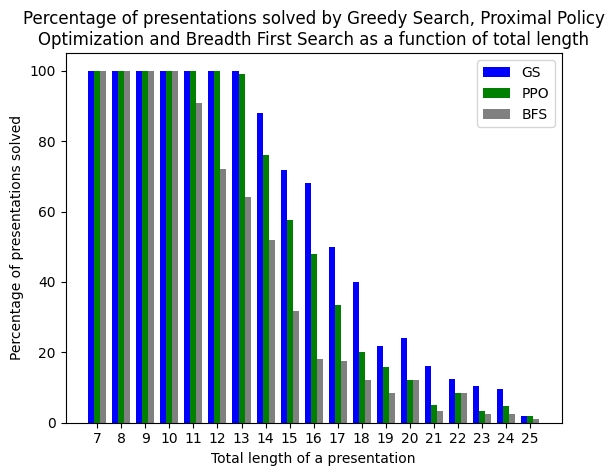

In [ ]:
lengths = sorted(list(length_to_gs_num_solved.keys()))
Y = [length_to_gs_num_solved.get(length, 0) / length_to_num_presentations[length] * 100 for length in lengths]
Z = [length_to_bfs_num_solved.get(length, 0) / length_to_num_presentations[length] * 100 for length in lengths]
W = [length_to_ppo_num_solved.get(length, 0) / length_to_num_presentations[length] * 100 for length in lengths]

X_axis = np.arange(len(lengths))

# Width of the bar
barWidth = 0.25

# Set position of bar on X axis
r1 = X_axis - barWidth
r2 = X_axis
r3 = X_axis + barWidth

# Make the plot
plt.bar(r1, Y, width=barWidth, label='GS', color='blue')
plt.bar(r2, W, width=barWidth, label='PPO', color='green')
plt.bar(r3, Z, width=barWidth, label='BFS', color='grey')

# Adding xticks
plt.xticks(X_axis, lengths)
plt.xlabel("Total length of a presentation")
plt.ylabel("Percentage of presentations solved")
plt.title("""Percentage of presentations solved by Greedy Search, Proximal Policy
Optimization and Breadth First Search as a function of total length""")
plt.legend()

# plt.savefig('/Users/alishehper/work/ac_paper/fig/performance_vs_length.png')

# plt.savefig("./Images/performance_vs_length.pdf")
# Display the figure
plt.show()


While PPO consistently outperformed BFS for
all values of n and for all lengths of presentations, it consistently underperformed
compared to the greedy search.

# Why AC is useful for RL?

It presents a unique and valuable set of challenges for advancing RL towards AGI:

1. **Sparse rewards**: Reward is only significantly positive upon reaching the target state (minimal tuple length), creating extreme sparsity.
2.  **Horizon control**: AC offers exceptional flexibility in setting episode lengths, unlike many other environments.
3. **Varying complexity**: Initial states range from trivially solvable to requiring potentially billions of steps, far exceeding the complexity of games like Go or chess, thus demanding scalable RL algorithms.
4. **Low computational cost**: The simplicity of AC actions (tuple operations) makes it computationally efficient compared to environments like Atari or MuJoCo.